In [458]:
REGION = "apac" # apac/emea/latam/usc
GB_THRESHOLD = 95 # we limit to top-cities containing GB_THRESHOLD% of GB, remaining cities have neglibible GB

In [459]:
import os
if not os.path.exists("{}_results".format(REGION)):
    os.mkdir("{}_results".format(REGION))

In [460]:
# %%bash
# source $VIRTUAL_ENV_DIR/python3/bin/activate

# pip install "scikit-learn==0.20.3"


In [461]:
import pandas as pd, numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

X = pd.read_csv("data/city_level_metrics_1_23_2022_to_1_29_2022_w_metadata_excluding_outliers_add_lat_lng.csv") #https://michelangelo-studio.uberinternal.com/file/d55c6275-b239-4d8b-81d5-ac2962a70d3f
X['city.mega_region'] = X['city.mega_region'].map({'APAC': 'apac', 'EMEA':'emea', 'LatAm': 'latam', 'US & Canada': 'usc'})
# to disable geo features, remove _add_lat_lng
#X.drop('city.lat', axis=1, inplace=True)
#X.drop('city.lng', axis=1, inplace=True)

# replace nulls
X.replace('\\N', np.nan, inplace=True)

if REGION != "global":
    # limit to LATAM
    X = X[X['city.mega_region'] == REGION]


# add GB column
gb = pd.read_csv("data/gb_by_city_id_jan_23_jan_29_2022.csv")
city_gb = dict(zip(gb.city_id, gb.gross_bookings_usd))
X['GB_in_MM'] = X['data.city_id'].map(city_gb)/1e6
X.sort_values('GB_in_MM', inplace=True, ascending=False)
X.reset_index(inplace=True, drop=True)
# add GB as pct of total
X['gb_pct_of_total'] = X.GB_in_MM/X.GB_in_MM.sum()*100
X['city_w_gb_pct'] = X.apply(lambda r: r['city.city_name'] + " - " + "%.2f%%" % r['gb_pct_of_total'], axis=1)
# add offers as pct of total
X['offers_pct_of_total'] = X.num_offers/X.num_offers.sum()*100
X['city_w_offers_pct'] = X.apply(lambda r: r['city.city_name'] + " - " + "%.2f%%" % r['offers_pct_of_total'], axis=1)
# drop supply surge as this column will be removed in future
X.drop('average_supply_surge', axis=1, inplace=True)


In [462]:
X.columns

Index(['data.city_id', 'city.city_name', 'city.region', 'city.sub_region',
       'city.mega_region', 'city.country_name', 'city.lat', 'city.lng',
       'num_offers', 'average_driver_canceled', 'average_surge_diff',
       'average_demand_surge', 'average_eta', 'average_rounded_eta',
       'average_fd_eta', 'average_eyeball_eta', 'average_rating',
       'average_forward_dispatched', 'average_starpower',
       'average_days_since_signup', 'average_days_since_first_trip',
       'average_trip_distance_haversine', 'average_is_fifo',
       'average_is_commute', 'average_is_rider_canceled_dispatch', 'GB_in_MM',
       'gb_pct_of_total', 'city_w_gb_pct', 'offers_pct_of_total',
       'city_w_offers_pct'],
      dtype='object')

In [463]:
X.shape

(274, 30)

26


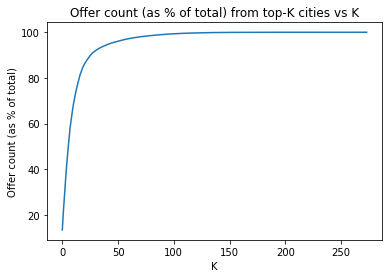

In [464]:
# find number of cities with top 90% of offers
X.sort_values('offers_pct_of_total', inplace=True, ascending=False)
plt.plot(np.arange(X.shape[0]), np.cumsum(X["offers_pct_of_total"]))
plt.xlabel("K")
plt.ylabel("Offer count (as % of total)")
plt.title("Offer count (as % of total) from top-K cities vs K")

offers_pct_of_total_at_k = np.cumsum(X["offers_pct_of_total"].tolist())
K = next(i for i in range(X.shape[0]) if offers_pct_of_total_at_k[i] > 90)
print(K)
#X["offers_pct_of_total"][:169].sum()

34


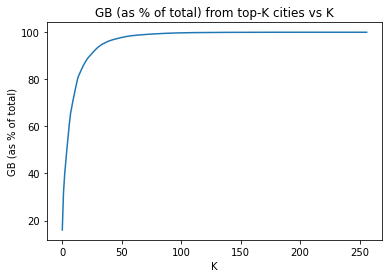

In [465]:
# find number of cities with top 90% of GB

X.sort_values('gb_pct_of_total', inplace=True, ascending=False)
plt.plot(np.arange(X.shape[0]), np.cumsum(X["gb_pct_of_total"]))
plt.xlabel("K")
plt.ylabel("GB (as % of total)")
plt.title("GB (as % of total) from top-K cities vs K")

gb_pct_of_total_at_k = np.cumsum(X["gb_pct_of_total"].tolist())
K = next(i for i in range(X.shape[0]) if gb_pct_of_total_at_k[i] > GB_THRESHOLD)
print(K)

In [466]:
# limit to top 90% GB cities or use all cities
use_all_cities = False
if use_all_cities:
    K = X.shape[0]
    
X = X[:K+1]
X.shape

(35, 30)

In [467]:
city_info = X[['data.city_id', 'city.city_name', 'city.mega_region', 'city.country_name', 'city.region', 'city.sub_region', 'offers_pct_of_total', 'gb_pct_of_total', 'city_w_offers_pct', 'city_w_gb_pct', 'num_offers', 'GB_in_MM', 'average_days_since_signup']] #, 'num_offers', 'GB_in_MM'
offers_pct_of_total = X.loc[:, 'offers_pct_of_total']
gb_pct_of_total = X.loc[:, 'gb_pct_of_total']

cols = [c for c in X.columns if c not in city_info.columns]
#X = X[cols]
X = pd.concat([X[cols], pd.get_dummies(X['city.mega_region'])], axis=1)
cols = X.columns

In [468]:
# perform feature normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.array(X)

/dsw/snapshots/snapshot_dsw_default_jupyter/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/dsw/snapshots/snapshot_dsw_default_jupyter/python3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


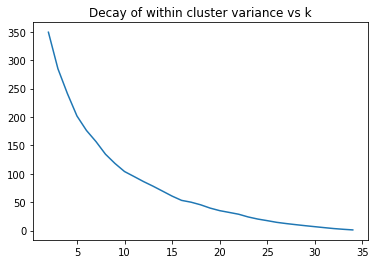

In [469]:
# find optimal number of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import mixture


feats_vec = X
# cluster the feature-vectors and obtain cluster memberships
# find optimal number of clusters

# try sum of within cluster-variance as a measure of goodness
def withinSS(feats_vec, labels, centers):
    result = 0
    for i in range(feats_vec.shape[0]):
        result += np.sum((feats_vec[i,] - kmeans.cluster_centers_[labels[i]])**2)
    return result

lowest_bic = np.infty 
withinSSList = []
silhouetteScoreList = []
n_components_range = range(2, min(feats_vec.shape[0], 50))
#n_components_range = range(2, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
bic = []
bic_1 = []
bic_2 = []
bic_3 = []
bic_4 = []
for n_components in n_components_range:
    # Fit a mixture of Gaussians with EM
    kmeans = KMeans(n_clusters=n_components, random_state = 1)
    kmeans.fit(feats_vec)
    labels = kmeans.labels_
    silhouetteScoreList.append(silhouette_score(feats_vec, labels, metric='euclidean'))
    withinSSList.append(withinSS(feats_vec, labels, kmeans.cluster_centers_))
    #print(bic)
    for cv_type in cv_types:
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(feats_vec)
        score = gmm.bic(feats_vec)
        bic.append(score)
        if cv_type == 'spherical': bic_1.append(score)
        if cv_type == 'tied': bic_2.append(score)
        if cv_type == 'diag': bic_3.append(score)
        if cv_type == 'full': bic_4.append(score)
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_kmm = gmm
        


plt.plot(range(2, 2 + len(withinSSList)), withinSSList)
plt.title("Decay of within cluster variance vs k")
plt.show()
plt.savefig("{}_results/kmeans_decay_city_count_{}.pdf".format(REGION, X.shape[0]))
plt.clf(); plt.close()

plt.plot(range(2, 2+ len(silhouetteScoreList)), silhouetteScoreList)
plt.title("Variation in silhouette score vs k")
plt.savefig("{}_results/silhouette_growth.pdf".format(REGION))
plt.clf(); plt.close()

#plt.ylim(ymax = , ymin = -50000)
plt.plot(range(2, 2 + len(bic_1)), bic_1, label = "Spherical")
plt.plot(range(2, 2 + len(bic_1)), bic_2, label = "Tied")
plt.plot(range(2, 2 + len(bic_1)), bic_3, label = "Diag")
plt.plot(range(2, 2 + len(bic_1)), bic_4, label = "Full")
plt.title("Variation in BIC vs k for GMM")
plt.legend(loc = "upper right", fontsize = 'x-small');
plt.savefig("{}_results/bic.pdf".format(REGION))
plt.clf(); plt.close()

In [470]:
# perform clustering
n_components = 10
kmeans = KMeans(n_clusters=n_components, random_state = 1)
#kmeans.fit(feats_vec) #

weighted = False
if weighted:
    kmeans.fit(feats_vec, sample_weight = gb_pct_of_total)
else:
    kmeans.fit(feats_vec) #, sample_weight = offers_pct_of_total, , sample_weight = gb_pct_of_total

labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

/dsw/snapshots/snapshot_dsw_default_jupyter/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Text(0.5, 1.0, 'RF importances of features')

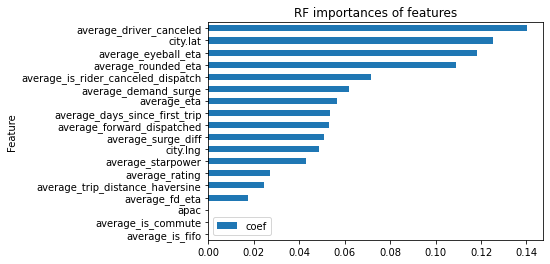

In [471]:
# visualize feature importances
from sklearn.ensemble import RandomForestClassifier

df = pd.DataFrame(feats_vec, columns=cols)
y = labels

rf = RandomForestClassifier(random_state=123)
rf.fit(df, y)


imp = pd.DataFrame(sorted([x for x in zip(cols, rf.feature_importances_)], key = lambda x : abs(x[1])), columns = ['Feature', 'coef'])
imp.index = imp['Feature']
imp.iloc[-20:].plot(kind = "barh")
plt.title("RF importances of features")

In [472]:
# store city clusters
from collections import defaultdict
labels = np.array(labels)
store_clusters = defaultdict(list)
for label in np.unique(labels):
    # find city dx with max GB
    city_idxs = sorted(np.where(labels == label)[0]) 
    max_idx = city_idxs[0]
    key = (label, city_info.loc[max_idx, 'gb_pct_of_total']) # store max GB as key
    store_clusters[key] = city_idxs

In [473]:
def distance(x, c):
    return np.sqrt(sum((x-c)**2))

sorted_result = []
clusters_list = []

for i, cluster_key in enumerate(sorted(store_clusters.keys(), key = lambda x: x[1], reverse=True)):
    cluster_gb = sum([city_info.loc[city_idx, 'gb_pct_of_total'] for city_idx in store_clusters[cluster_key]])
    print("\n" + "Cluster {} - {:.2f}% GB".format(i, cluster_gb) + '\n' + "-------")
    sorted_result.append([""]*city_info.shape[1] + ["Cluster {} - {:.2f}% GB".format(i, cluster_gb),""])
    for city_idx in store_clusters[cluster_key]:
        print(city_info.loc[city_idx, 'city_w_gb_pct'])
        sorted_result.append(list(city_info.loc[city_idx]) + [i, distance(feats_vec[city_idx], cluster_centers[cluster_key[0]])])
    sorted_result.append(["", "", "", "", "", ""])
    clusters_list.append({'cluster_gb': cluster_gb, 'cities': [city_info.loc[city_idx].to_dict() for city_idx in store_clusters[cluster_key]]})



Cluster 0 - 18.29% GB
-------
Melbourne - 16.01%
Gold Coast - 2.28%

Cluster 1 - 19.69% GB
-------
Sydney - 15.69%
Auckland - 2.56%
Canberra - 0.89%
Christchurch - 0.56%

Cluster 2 - 12.20% GB
-------
Hong Kong - 8.00%
Hyderabad - 2.32%
Dhaka - 1.31%
Jaipur - 0.57%

Cluster 3 - 8.04% GB
-------
Taipei - 5.82%
Taichung - 1.15%
Kaohsiung - 0.57%
Taoyuan - 0.50%

Cluster 4 - 15.01% GB
-------
Perth - 5.54%
Brisbane - 5.07%
Adelaide - 2.32%
Wellington - 0.86%
Hobart - 0.53%
Cairns - 0.37%
Darwin - 0.33%

Cluster 5 - 12.27% GB
-------
Delhi NCR - 5.29%
Mumbai - 4.22%
Kolkata - 2.76%

Cluster 6 - 4.72% GB
-------
Bangalore - 2.61%
Chennai - 1.06%
Pune - 1.05%

Cluster 7 - 1.67% GB
-------
Seoul - 1.11%
Tokyo - 0.57%

Cluster 8 - 1.55% GB
-------
Colombo - 0.81%
Ahmedabad - 0.42%
Chandigarh - 0.32%

Cluster 9 - 1.58% GB
-------
Newcastle - 0.63%
Sunshine Coast - 0.51%
Geelong - 0.44%


In [474]:
# dump to csv
sorted_result = pd.DataFrame(sorted_result, columns = list(city_info.columns) + ['cluster', 'distance_from_cluster_center'])

In [475]:
sorted_result[["cluster", "city.city_name", "gb_pct_of_total", "offers_pct_of_total", "city.mega_region", "city.country_name", "city.region", "city.sub_region", "data.city_id", "distance_from_cluster_center"]].to_csv("{}_results/clustering_result_weighted_{}_city_count_{}.csv".format(REGION, weighted, X.shape[0]), index=False)

In [476]:
print(cols)

Index(['city.lat', 'city.lng', 'average_driver_canceled', 'average_surge_diff',
       'average_demand_surge', 'average_eta', 'average_rounded_eta',
       'average_fd_eta', 'average_eyeball_eta', 'average_rating',
       'average_forward_dispatched', 'average_starpower',
       'average_days_since_first_trip', 'average_trip_distance_haversine',
       'average_is_fifo', 'average_is_commute',
       'average_is_rider_canceled_dispatch', 'apac'],
      dtype='object')


In [477]:
# dump to pkl
import joblib
joblib.dump(clusters_list, "clusters/{}.pkl".format(REGION))

['clusters/apac.pkl']

# Visualization

(-5.0, 5.0)

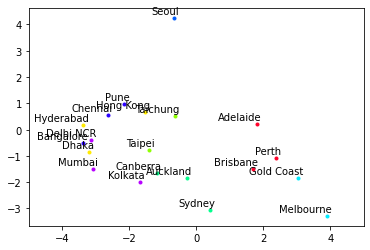

In [478]:
# PCA visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_2 = pca.fit_transform(X)

cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/n_components) for i in range(n_components)]
colors_list = [colors[c] for c in labels]

N = 20

# zip joins x and y coordinates in pairs
for i in range(N):
    plt.plot(X_2[i,0], X_2[i, 1], ".", color = colors_list[i])
    label = city_info.iloc[i, 1]
    plt.annotate(label, # this is the text
                 (X_2[i, 0],X_2[i, 1]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(5,2), # distance from text to points (x,y)
                 ha='right',
                 va='bottom',
                 fontsize=10) # horizontal alignment can be left, right or center
    
plt.xlim(-5, 5)

In [479]:
# t SNE visualization
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=31, n_components=2, init='pca', n_iter=5000, method='exact')
vectors = tsne.fit_transform(X)

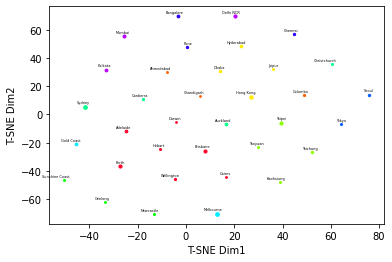

In [480]:
N = X.shape[0]

city_ids_to_highlight = {805, 148, 204, 781, 144, 146, 533, 1408, 1315, 1359, 1395, 1379, 1388, 1325, 1390, 1423, 1335, 1275}

# zip joins x and y coordinates in pairs
for i in range(N):
    city_id = city_info.iloc[i, 0]
    plt.plot(vectors[i,0], vectors[i, 1], ".", color = colors_list[i], markersize = np.log(100*city_info.loc[i, 'gb_pct_of_total']))
        
    label = city_info.iloc[i, 1]
    plt.annotate(label, # this is the text
                 (vectors[i, 0],vectors[i, 1]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(5,2), # distance from text to points (x,y)
                 color = "black" if city_id not in city_ids_to_highlight else "blue",
                 ha='right',
                 va='bottom',
                 fontsize=3.5) # horizontal alignment can be left, right or center
plt.xlabel("T-SNE Dim1")
plt.ylabel("T-SNE Dim2")
plt.savefig("{}_results/city_embeddings_city_count_{}.pdf".format(REGION, N))



In [481]:
set(sorted_result[~sorted_result.cluster.isna()]['cluster']) - set(sorted_result[sorted_result['data.city_id'].isin(city_ids_to_plot)]['cluster'])

NameError: name 'city_ids_to_plot' is not defined

In [ ]:
len(set(city_ids_to_plot) & set(city_info['data.city_id']))